# Texture synthesis

* Introduction
* Texture synthesis with non-parametric sampling
* Texture synthesis with image pyramids
* Texture synthesis with convolutional neural networks

## 1 Introduction

The problem of texture synthesis in computer vision involves generating a texture image of arbitrary size from a given sample texture. This notebook shows the implementations of algorithms to perform texture synthesis and the obtained results.

## 2 Texture synthesis with non-parametric sampling

In the approach proposed by [1], the texture image is generated by iteratively sampling from the sample texture image. For every unknown pixel to be generated, its neighbourhood window of some fixed size is compared with every patch of the same size in the sample texture image, and the closest matching patches found. The value of the unknown pixel in the generated texture image is then taken to be that from the closest texture patch at the same location. The Gaussian weighted sum of squared differences (SSD), which accounts for the greater importance of pixels closer to the pixel to be generated, was used as the measure of closeness between patches. Following [1], the output texture images were generated in scan-line order.

The cells below show the generated textures with the first pixel of the output texture initialised randomly. With square windows of sizes 10$\times$10 used to find matching texture patches, very reasonable results were obtained. The algorithm was able to capture the regularities of sample textures and no visible abrupt discontinuities in the patterns were observed in the generated textures.

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

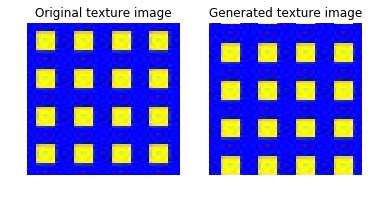

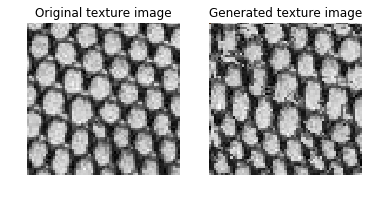

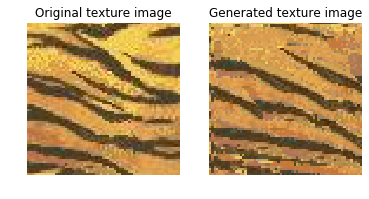

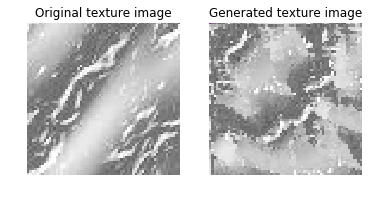

In [2]:
from non_param_sampling import *

for f in os.listdir('./textures'):
    _, fext = os.path.splitext(f)
    if (fext==".jpg"):
        src_texture = np.array(Image.open('./textures/'+f)) / 255

        generated_texture = synthesize_texture(src_texture)

        plt.subplot(1,2,1)
        plt.imshow(src_texture)
        plt.axis('off')
        plt.title('Original texture image')
        plt.subplot(1,2,2)
        plt.imshow(generated_texture)
        plt.axis('off')
        plt.title('Generated texture image')
        plt.show()

Additionally, the implementation of the algorithm was also tested by initialising the top left corner of the output texture with a portion of the sample texture. As seen below, with this initialisation, the algorithm gave output textures that were visually indistinguishable from the sample textures. Compared to the above results with random initialisations, the generated textures here showed very little variations, the generated textures essentially copied extensions of the sample textures.

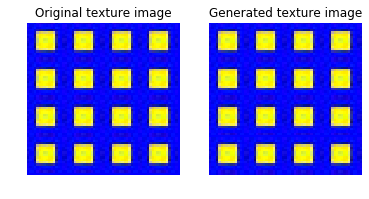

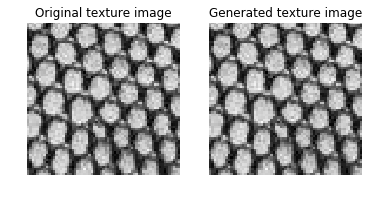

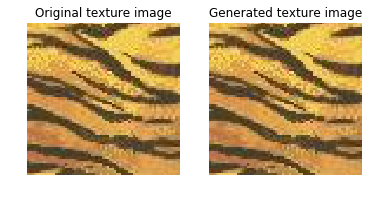

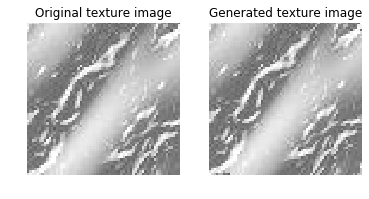

In [3]:
for f in os.listdir('./textures'):
    _, fext = os.path.splitext(f)
    if (fext==".jpg"):
        src_texture = np.array(Image.open('./textures/'+f)) / 255

        generated_texture = synthesize_texture(src_texture, random_init=False)

        plt.subplot(1,2,1)
        plt.imshow(src_texture)
        plt.axis('off')
        plt.title('Original texture image')
        plt.subplot(1,2,2)
        plt.imshow(generated_texture)
        plt.axis('off')
        plt.title('Generated texture image')
        plt.show()

## 3 Texture synthesis with image pyramids

The use of image pyramids to synthesize textures was proposed in [2]. Image pyramids capture the sample textures at different scales which should be helpful in reproducing representative features of the source texture. Following the algorithm described in [2], image pyramids containing the low-pass and high-pass filtered images of the source and generated textures were constructed. In an iterative fashion, the histograms of filtered images at every level of the pyramid were matched, as well as that of the sample and generated textures. The generated texture should reasonably resemble the source texture after some numbers of iterations.

Outputs of the implemented algorithm on sample textures are shown below. While the global structure of the source texture was captured, the algorithm fails to reproduce regularities and shapes within the source texture. The poorer performance of this algorithm may however be due to the choice of image pyramid used in this implementation. The Gaussian kernel was used to filter the source texture when constructing the image pyramid. Since the Gaussian kernel is radially symmetric, it is expected that structures of different shapes and orientations within the source texture cannot be fully captured. Improved performances can be expected with the use of image pyramids that can account for different orientations, for instance steerable image pyramids.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from pyramid_synthesis import *

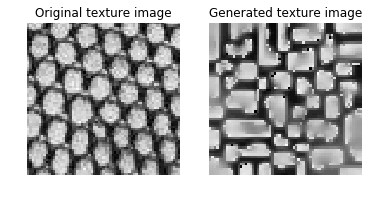

In [2]:
src_texture = np.array(Image.open('./textures/texture6.jpg'))[:,:,0][:,:,None]
generated_texture = np.uint8(np.random.random(src_texture.shape) * 255)

generated_texture = match_texture(generated_texture, src_texture, 120)

plt.subplot(1,2,1)
plt.imshow(src_texture[:,:,0], cmap='gray')
plt.axis('off')
plt.title('Original texture image')
plt.subplot(1,2,2)
plt.imshow(generated_texture, cmap='gray')
plt.axis('off')
plt.title('Generated texture image')
plt.show()

## 4 Texture synthesis with convolutional neural networks

Convolutional neural networks can be used to perform texture synthesis. As described by [3], the feature maps of some input image given by CNNs pretrained on large image classification datasets provide low and high level representations of that input image. The information of such representations define a model for textures, much unlike the sampling based approach where no explicit model is presence. The presence of such a model in synthesizing textures should lead then to improved results.

The feature map at any layer of a CNN may be represented as a gram matrix, which captures the correlations between the different channels. To synthesize textures from a randomly initialised image, the gram matrices at the different layers of the CNN for the sample and output images are found, and the MSE loss describing the differences between the gram matrices for the two images computed. Then, the output image is iteratively updated to minimise the loss function.

In the following implementations, CNNs of the VGG-19 and SqueezeNet architectures pretrained on the ImageNet dataset were considered. The parameters of the optimization procedure were varied such that the loss function can consistently decrease over all iterations. The generated textures from uniformly randomised images are shown below.

In [1]:
import numpy as np

import torch
import torchvision

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from neural_texture_synthesis import *

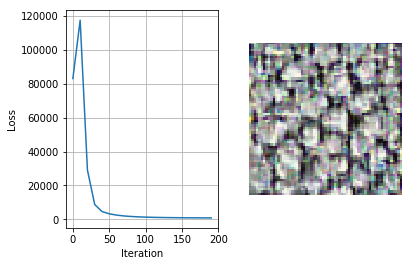

In [2]:
src_texture = preprocess(Image.open('./textures/texture6.jpg'))

model = torchvision.models.squeezenet1_1(pretrained=True).features
for param in model.parameters():
    param.requires_grad = False
model.eval()

output_image = generate_texture(model, src_texture, cnn_layers=[1,4,6,7],
                                layer_weights=[20000,500,12,1], reg_weight=0.05,
                                max_iter=200, learn_rate=2, verbose = False)

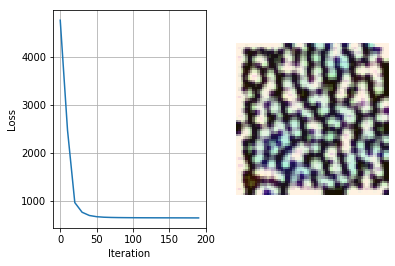

In [3]:
src_texture = preprocess(Image.open('./textures/texture6.jpg'))

model = torchvision.models.vgg19(pretrained=True).features
for param in model.parameters():
    param.requires_grad = False
model.eval()
    
output_image = generate_texture(model, src_texture, cnn_layers=[0,2,5,7,10],
                                layer_weights=[20000,500,12,1,0.1], reg_weight=0.05,
                                max_iter=200, learn_rate=2, verbose = False)

**Notes on texture synthesis**

The approaches described above to generate textures require an iterative process to generate the desired texture images. Although producing reasonably appealing results, two main issues remain: 
1. The rendering process is iterative and may be slow,
2. Different parameter values may be required for every different texture to be generated.

To address the two issues listed above, assuming the availiability of unlabeled training texture images, a Generative Adverserial Network (GAN) may be trained to generate texture images. GANs consist of a generator and a discriminator network, trained jointly in a mini-max fashion. At test time, only the generator network needs to be used to generate texture images from some random input. Numerous works have proved the effectiveness of GANs in deep unsupervised learning applied to images.

## References

[1] A. Efros and T. Leung. Texture Synthesis by Non-parametric Sampling. In *ICCV*, 1999.

[2] D. Heeger and J. Bergen. Pyramid-Based Texture Analysis/ Synthesis. In *SIGGRAPH*, 1995.

[3] L. Gatys, A. Ecker and M. Bethge. Texture Synthesis using Convolutional Neural Networks. In *NIPS*, 2015.